In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

#shift-tab on a function gets its docstring

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)

import constants
imp.reload(constants)
from constants import *

In [4]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

In [5]:
from scipy import stats

# Compare Fourier Transform with that of pycbc

In [8]:
def fourier_transform_uniform_sampled_waveform(h):
    """Fourier transform a uniformly sampled waveform.
    If possible, pad the waveform so its length is a power of 2.
    
    """
    dt = h.x[1]-h.x[0]
    npoints = len(h.x)
    
    # Get data in complex format
    data = h.amp * np.exp(1.0j*h.phase)
    
    # Do the Fourier transform
    data_tilde = dt*np.fft.fft(data)
    freqs = np.arange(npoints)/(npoints*dt)
    
    # Convert data to Waveform object
    return wave.Waveform.from_complex(freqs, data_tilde)

In [9]:
mf_min = 0.005
delta_tbym = 10.0
approximant = 'SpinTaylorT4'
### !!!!!!!!! amplitude_order should be 0 to avoid junk from higher order modes !!!!!!!!!!
amp_ord = 0

q = 0.6
spin1z = 0.4
spin2z = 0.2
lambda1 = 2000.0
lambda2 = 1000.0

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0


h_lal = dimensionless_td_waveform(approximant=approximant, q=q, 
                               spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                               spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                               lambda1=lambda1, lambda2=lambda2, 
                               mf_min=mf_min, delta_tbym=delta_tbym, amplitude_order=amp_ord)

h_tilde_lal = fourier_transform_uniform_sampled_waveform(h_lal)

In [10]:
# dimensionless -> physical:
# Pick fiducial mtot = 1Msun and distance = 1Mpc
# pycbc expects units of Msun and Mpc
mtot = 1.0
distance = 1.0
inclination = 0.0

mass1 = mtot / (1.0 + q)
mass2 = mtot * q / (1.0 + q)

f_min = C_SI**3 * mf_min / (G_SI * MSUN_SI * mtot)
delta_t = G_SI * MSUN_SI * mtot * delta_tbym / C_SI**3

hp_pycbc, hc_pycbc = pycbc.waveform.get_td_waveform(approximant=approximant, 
            mass1=mass1, mass2=mass2, 
            spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
            spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
            lambda1=lambda1, lambda2=lambda2,
            distance=distance, inclination=inclination, 
            delta_t=delta_t, f_lower=f_min, f_ref=f_min, 
            phase_order=-1, tidal_order=-1, amplitude_order=amp_ord, spin_order=-1)

# Time domain dimensionless waveform
h_pycbc = wave.Waveform.from_hp_hc(np.array(hp_pycbc.sample_times), np.array(hp_pycbc), np.array(hc_pycbc))
h_pycbc = wave.physical_to_dimensionless_time(h_pycbc, mtot, distance)

# Frequency domain dimensionless waveform
hp_tilde_pycbc = hp_pycbc.to_frequencyseries()
hc_tilde_pycbc = hc_pycbc.to_frequencyseries()

freq = np.array(hp_tilde_pycbc.sample_frequencies)
h_tilde_pycbc = np.array(hp_tilde_pycbc) + 1.0j*np.array(hc_tilde_pycbc)
h_tilde_pycbc = wave.Waveform.from_complex(freq, h_tilde_pycbc)
h_tilde_pycbc = wave.physical_to_dimensionless_freq(h_tilde_pycbc, mtot, distance)

In [11]:
print h_lal.x[1]-h_lal.x[0], h_lal.x[0], h_lal.x[-1]
print h_pycbc.x[1]-h_pycbc.x[0], h_pycbc.x[0], h_pycbc.x[-1]

10.0 -4930.00004955 -4.95524552838e-05
10.0 -4930.00004955 -4.95524545794e-05


(<matplotlib.figure.Figure at 0x10a1779d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10aea4350>)

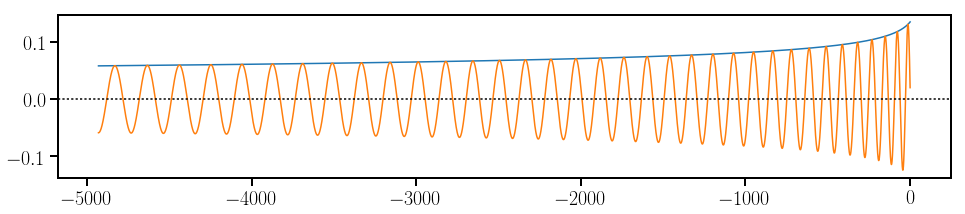

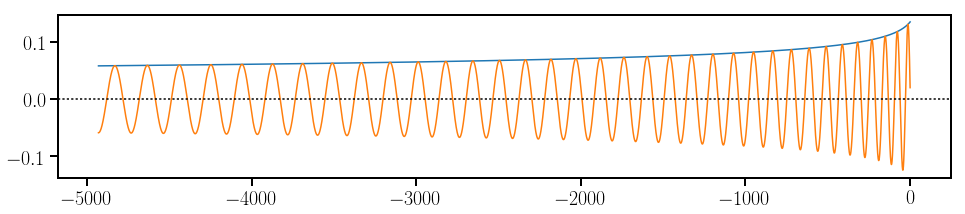

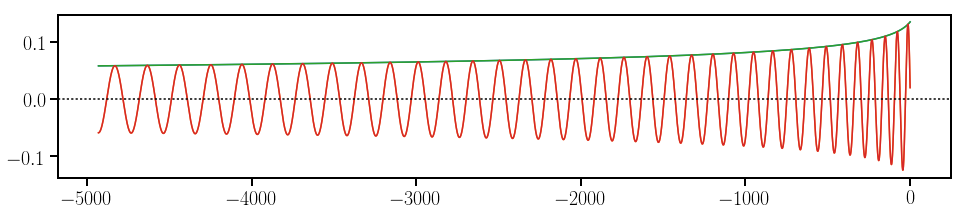

In [12]:
wave.plot_waveforms([h_lal], npoints=100000)
wave.plot_waveforms([h_pycbc], npoints=100000)
wave.plot_waveforms([h_pycbc, h_lal], xi=-6000, xf=1000, npoints=100000)

In [13]:
print h_tilde_lal.amp[5]/h_tilde_pycbc.amp[5]
print h_tilde_lal.x[-1], h_tilde_pycbc.x[-1]
print len(h_tilde_lal), len(h_tilde_pycbc)

1.0
0.0997975708502 0.05
494 248


(<matplotlib.figure.Figure at 0x10be0a790>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10bddc890>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10c1fced0>))

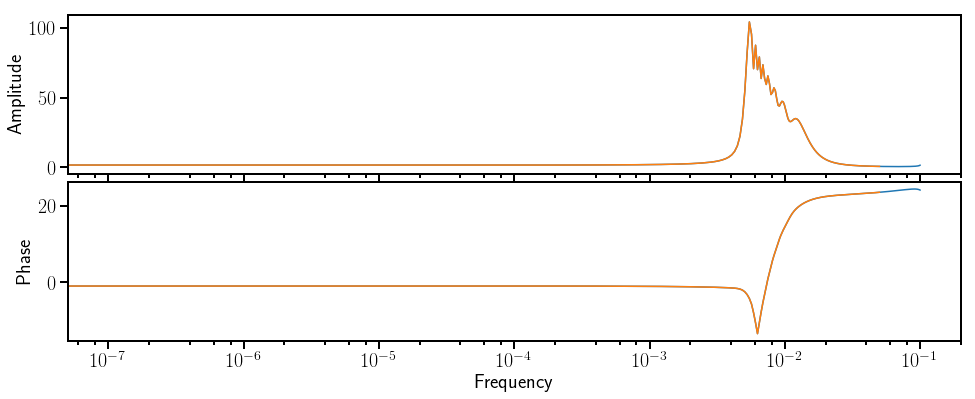

In [14]:
wave.plot_waveforms_fd([h_tilde_lal, h_tilde_pycbc])

In [15]:
print hp_tilde_pycbc.epoch, hp_pycbc.start_time

-0.024282671 -0.024282671


# Test windowing

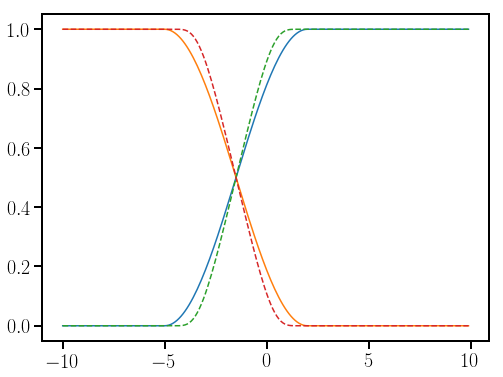

In [16]:
xarr = np.arange(-10, 10, 0.1)
xi = -5
xf = 2
h_on = np.array([window.hann_on(x, xi, xf) for x in xarr])
#print h_on
h_off = np.array([window.hann_off(x, xi, xf) for x in xarr])
#print h_off
p_on = np.array([window.planck_on(x, xi, xf) for x in xarr])
#print p_on
p_off = np.array([window.planck_off(x, xi, xf) for x in xarr])
#print p_off
plt.plot(xarr, h_on)
plt.plot(xarr, h_off)
plt.plot(xarr, p_on, ls='--')
plt.plot(xarr, p_off, ls='--')

(<matplotlib.figure.Figure at 0x106a07210>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10a86c1d0>)

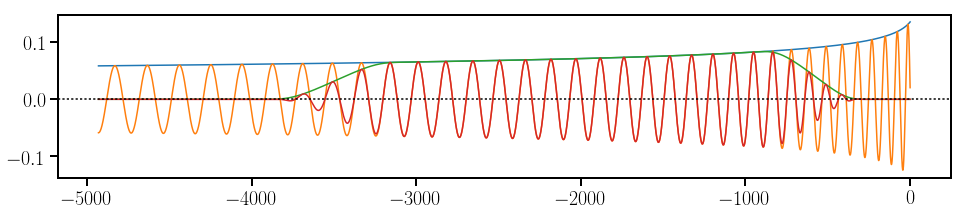

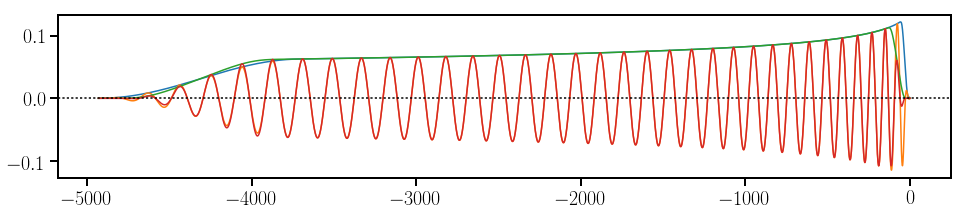

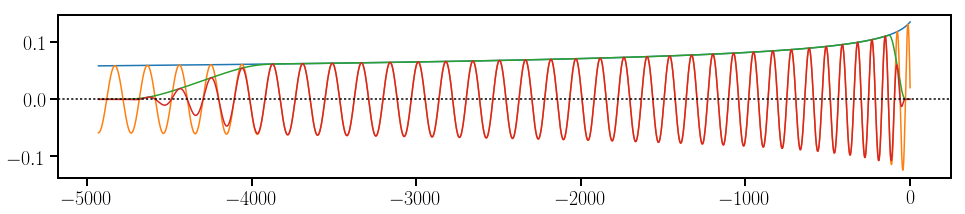

In [17]:
h_winx = h_lal.copy()
h_winx = window.window_on(h_winx, -4000, -3000, win='planck')
h_winx = window.window_off(h_winx, -1000, -200, win='planck')

h_winf_h = h_lal.copy()
h_winf_h = window.window_freq_on(h_winf_h, 0.005, 0.0055, win='hann')
h_winf_h = window.window_freq_off(h_winf_h, 0.015, 0.017, win='hann')

h_winf_p = h_lal.copy()
h_winf_p = window.window_freq_on(h_winf_p, 0.005, 0.0055, win='planck')
h_winf_p = window.window_freq_off(h_winf_p, 0.013, 0.017, win='planck')

wave.plot_waveforms([h_lal, h_winx], npoints=100000)
wave.plot_waveforms([h_winf_h, h_winf_p], npoints=100000)
wave.plot_waveforms([h_lal, h_winf_p], npoints=100000)

# Test conditioned waveform

When you shift the Fourier transformed start time back to the original value
determined by lalsimulation, it doesn't end exactly at t=0. 

--It differs by some value $<\Delta t$.

--You should instead set t=0 to be some specific frequency that you choose to correspond to $t_{\rm coalescence}$.
Then, take the Fourier transform, and adjust with the new start time.

--!!! This is the reason that adjusting delta_t causes a slowly accumulating *LINEAR* phase shift when you
compare the conditioned waveforms for two different delta_t values!!!

--!!! And this only happens when use_start_time=True !!!

--If you set the window off appropriately, the waveform won't depend significantly on which $\Delta t$ you choose.
This happens if the amplitude drops to zero before the last $\Delta t$ of the waveform.

#### The Fourier transform can be really slow when npoints is not easily factorable. Use a power of 2 since you're padding the waveform anyway.

In [18]:
# prime number:
nprime = 8191
# power of 2:
npow2 = 8192
a_prime = np.random.rand(nprime)
a_pow2 = np.random.rand(npow2)

In [19]:
%timeit np.fft.fft(a_prime)
%timeit np.fft.fft(a_pow2)

10 loops, best of 3: 104 ms per loop
1000 loops, best of 3: 203 µs per loop


In [20]:
def next_pow_2(time_total, delta_t):
    """Get the number of points satisfying 2**n for in n,
    that will contain a uniformly spaced array of length npoints = time_total / delta_t.
    
    Returns
    -------
    npow2 : int
        The next power of 2 >= npoints.
    """
    # Number of uniformly sampled points in interval T is the floor of T/dt.
    npoints = np.floor(time_total / delta_t)
    
    # Take base-2 log to get current power of 2,
    # Then round up and cast as int
    next_exponent = int(np.ceil(np.log2(npoints)))
    return 2**next_exponent


def zero_pn_coalescence_time(mf_low, q):
    """Time to coalescence tbym_coal starting at a frequency mf_low.
    Uses leading order (0PN) coalescence time.
    mf_low, tbym_coal are in geometric units.
    """
    eta = q/(1.0+q)**2
    return (5.0/(256.0*np.pi*mf_low*eta)) * (np.pi*mf_low)**(-5.0/3.0)


def calculate_coalescence_time(h, f_coal):
    """Calculate the time of coalescence
    using a specific frequency f_coal as the definition of coalescence time.
    """
    toff = window.interpolate_time_of_frequency(h)
    
    # Check that you're not requesting a frequency beyond the highest available
    fmax = toff.get_knots()[-1]
    if f_coal>fmax:
        raise Exception, 'f_coal='+str(f_coal)+' is higher than highest frequency'+str(fmax)+'.'
        
    t_coal = toff(f_coal)
    return float(t_coal)

In [21]:
def condition_waveform(h,
                       winon_i, winon_f, winoff_i, winoff_f, 
                       n_ext,
                       trunc_i, trunc_f, npoints=10000, 
                       win='planck', f_coalescence=None, remove_start_phase=True):
    """Generate a conditioned Frequency-domain waveform from a uniformly sampled time-domain waveform.
    1. Window the beginning and end.
    2. Pad the end with zeros so all the waveforms in the training set have the exact same time samples.
    3. Fourier transform the waveform.
    4. Optional time shift to set coalescence frequency to t=0. (Default is start of waveform at t=0.)
    5. Resample the waveform, truncating the beginning and end to remove the windowing effect.

    Parameters
    ----------
    h : Waveform
        Uniformly sampled waveform.
    winon_i : Initial frequency of on window.
    winon_f : Final frequency of on window.
    winoff_i : Initial frequency of off window.
    winoff_f : Final frequency of off window. Should be less than the ending frequency of the waveform h.
    n_ext : int
        Number of samples for the extended (padded) waveform.
        All training set waveforms should have the same time samples.
        A power of 2 will make the Fourier transform efficient.
        If the phase of the Fourier-transformed waveform doesn't look correctly unwrapped,
        increase n_ext so that delta_f will be smaller. 
    trunc_i : Initial frequency of the truncated waveform after Fourier transforming.
    trunc_f : Final frequency of the truncated waveform after Fourier transforming.
    npoints : int
        number of logarithmically-spaced samples for the final conditioned waveform.
    win : 'hann' or 'planck'
        Type of window to use.
    f_coalescence : float
        Reference frequency for the Fourier transformed waveform.
        The waveform will be shifted such that the time at this frequency is at t=0.
        The shifting is done in the frequency domain.
        This is done so that the waveform is a smooth function of the waveform parameters.
    remove_start_phase : bool
        Set the phase at the start of the conditioned waveform to 0.
    
    Returns
    -------
    h_tilde : Waveform
        The conditioned, Fourier-transformed, and resampled waveform.
    """

    
    # Get data about the waveforms
    n_data = len(h.x)
    t_start = h.x[0]
    delta_t = h.x[1]-h.x[0]
    
    # 1. Window the waveform
    h = h.copy()
    h = window.window_freq_on(h, winon_i, winon_f, win=win)
    h = window.window_freq_off(h, winoff_i, winoff_f, win=win)

    ##### 2. Extend the waveform #####
    # Set new times
    times_ext = h.x[0] + delta_t*np.arange(n_ext)
    # Set new amplitude
    amp_ext = np.zeros(n_ext)
    amp_ext[:n_data] = h.amp
    # Set new phase
    # (Make phase continuous even when amplitude goes to zero)
    phase_ext = np.ones(n_ext)*h.phase[-1]
    phase_ext[:n_data] = h.phase
    h_ext = wave.Waveform.from_amp_phase(times_ext, amp_ext, phase_ext)
    
    # 3. Fourier transform
    h_tilde = fourier_transform_uniform_sampled_waveform(h_ext)
    
    # 4. Optional time shift to set the coalescence time to t=0.
    if f_coalescence is not None:
        t_coal = calculate_coalescence_time(h, f_coalescence)
        dt_insp = t_coal - t_start
        h_tilde.phase += 2.*np.pi*h_tilde.x*dt_insp
        
    # 5. Resample and truncate waveform
    wave.resample_uniform(h_tilde, xi=trunc_i, xf=trunc_f, npoints=npoints, spacing='log', order=2)
    
    # Optionally zero the start phase of the truncated waveform
    h_tilde.add_phase(remove_start_phase=remove_start_phase)
    
    return h_tilde

In [22]:
mf_to_f(0.0001, 2.0), mf_to_f(0.008, 2.8), mf_to_f(0.014, 2.8), 1.0/(2.0*20.0)

(10.151272175850124, 580.0726957628643, 1015.1272175850124, 0.025)

16993795.3652 2097152
458652 458652
[ -1.00000881e+01  -8.81403507e-05]


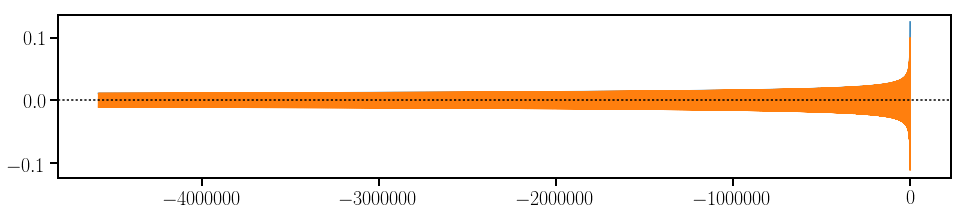

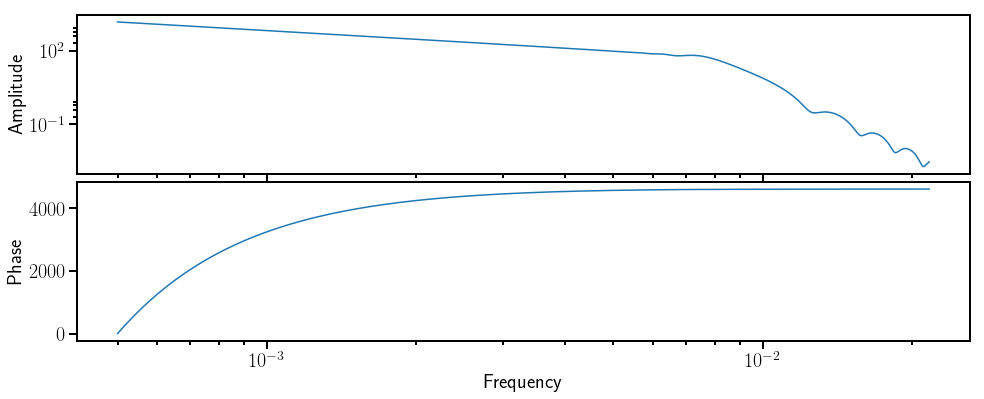

In [23]:
q = 0.6
spin1z = -0.7
spin2z = 0.2
lambda1 = 2000.0
lambda2 = 1000.0

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0

f_min = 0.0004
delta_t = 10.0
approximant = 'SpinTaylorT4'
amp_ord = 0

min_total_time = 4.0*zero_pn_coalescence_time(f_min, 1.0)
n_ext = next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

winon_i = f_min
winon_f = 0.0005
winoff_i = 0.008
winoff_f = 0.010
trunc_i = winon_f
trunc_f = MF_ISCO
npoints = 10000
win = 'planck'
f_coalescence = winoff_f


h = dimensionless_td_waveform(approximant=approximant, q=q, 
                               spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                               spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                               lambda1=lambda1, lambda2=lambda2, 
                               mf_min=f_min, delta_tbym=delta_t, amplitude_order=amp_ord)

print len(h), len(h.x)
print h.x[-2:]
wave.plot_waveforms([h], npoints=100000)


h_cond1 = condition_waveform(h,
                       winon_i, winon_f, winoff_i, winoff_f, 
                       n_ext,
                       trunc_i, trunc_f, npoints=npoints, 
                       win=win, f_coalescence=f_coalescence, remove_start_phase=True)

fig, (ax1, ax2) = wave.plot_waveforms_fd([h_cond1])
ax1.set_yscale('log')

In [7]:
q = 1.0
spin1z = 0.4
spin2z = 0.2
lambda1 = 2000.0
lambda2 = 1000.0

spin1x = 0.0
spin1y = 0.0
spin2x = 0.0
spin2y = 0.0

f_min = 0.00009
delta_t = 20.0
approximant = 'SpinTaylorT4'
amp_ord = 0

min_total_time = 2.0*zero_pn_coalescence_time(f_min, q)
n_ext = next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

winon_i = f_min
winon_f = 0.0001
winoff_i = 0.013
winoff_f = 0.017
trunc_i = winon_f
trunc_f = MF_ISCO
npoints = 10000
win = 'planck'
f_coalescence = winoff_f


h = dimensionless_td_waveform(approximant=approximant, q=q, 
                               spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                               spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                               lambda1=lambda1, lambda2=lambda2, 
                               mf_min=f_min, delta_tbym=delta_t, amplitude_order=amp_ord)

print len(h), len(h.x)
print h.x[-2:]
wave.plot_waveforms([h], npoints=100000)


h_cond1 = condition_waveform(h,
                       winon_i, winon_f, winoff_i, winoff_f, 
                       n_ext,
                       trunc_i, trunc_f, npoints=npoints, 
                       win=win, f_coalescence=f_coalescence, remove_start_phase=True)

fig, (ax1, ax2) = wave.plot_waveforms_fd([h_cond1])
ax1.set_yscale('log')
#ax1.axhline(1.0, ls=':', c='k')
#ax1.set_ylim(0.5, 1.5)
ax1.set_xlim(9.0e-5, 0.1)

NameError: name 'zero_pn_coalescence_time' is not defined

453705113.119 67108864
453705113.119 33554432


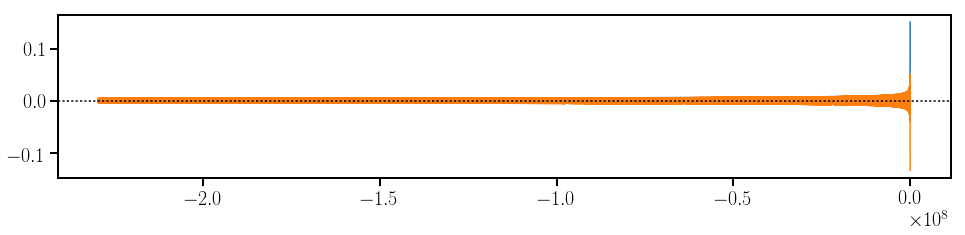

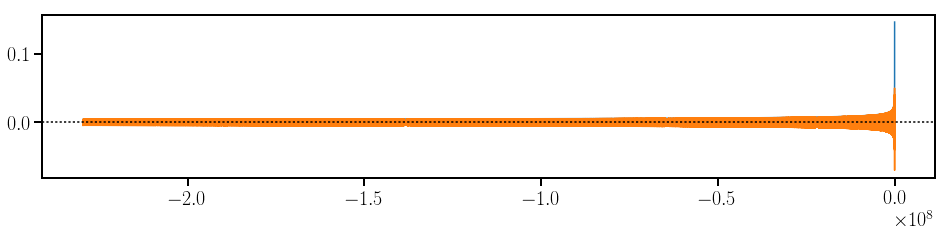

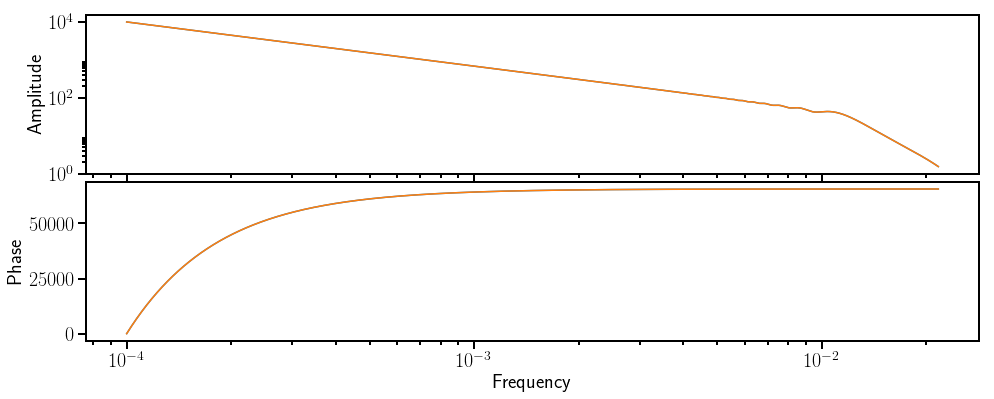

In [244]:
delta_t = 10.0
min_total_time = 2.0*zero_pn_coalescence_time(f_min, q)
n_ext = next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

h1 = dimensionless_td_waveform(approximant=approximant, q=q, 
                               spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                               spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                               lambda1=lambda1, lambda2=lambda2, 
                               mf_min=f_min, delta_tbym=delta_t, amplitude_order=amp_ord)
wave.plot_waveforms([h1], npoints=100000)
h_cond1 = condition_waveform(h1,
                       winon_i, winon_f, winoff_i, winoff_f, 
                       n_ext,
                       trunc_i, trunc_f, npoints=npoints, 
                       win=win, f_coalescence=f_coalescence, remove_start_phase=True)


delta_t = 20.0
min_total_time = 2.0*zero_pn_coalescence_time(f_min, q)
n_ext = next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

h2 = dimensionless_td_waveform(approximant=approximant, q=q, 
                               spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                               spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                               lambda1=lambda1, lambda2=lambda2, 
                               mf_min=f_min, delta_tbym=delta_t, amplitude_order=amp_ord)
wave.plot_waveforms([h2], npoints=100000)
h_cond2 = condition_waveform(h2,
                       winon_i, winon_f, winoff_i, winoff_f, 
                       n_ext,
                       trunc_i, trunc_f, npoints=npoints, 
                       win=win, f_coalescence=f_coalescence, remove_start_phase=True)

#h_cond1.amp *= h_cond1.x**(7.0/6.0) / (h_cond1.amp[0]*h_cond1.x[0]**(7.0/6.0))
#h_cond2.amp *= h_cond2.x**(7.0/6.0) / (h_cond2.amp[0]*h_cond2.x[0]**(7.0/6.0))

fig, (ax1, ax2) = wave.plot_waveforms_fd([h_cond1, h_cond2])
ax1.set_yscale('log')
#ax1.axhline(1.0, ls=':', c='k')
#ax1.set_ylim(0.5, 1.5)
#ax1.set_xlim(0.0005, 0.03)

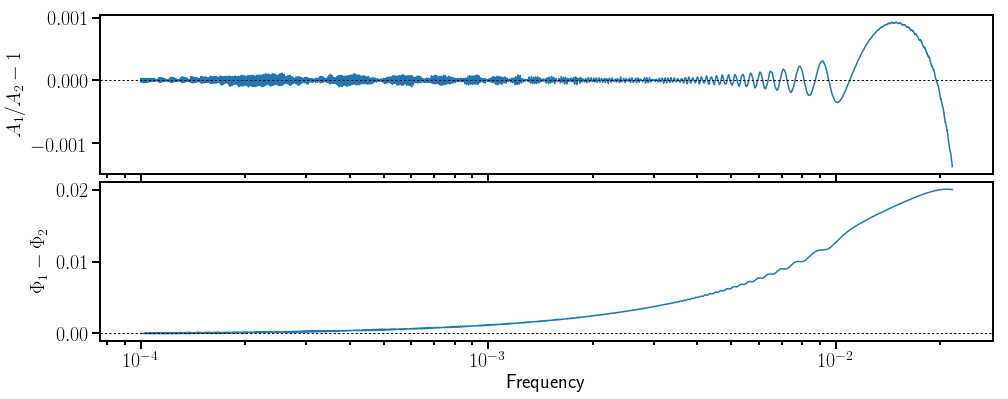

In [245]:
fig, (ax1, ax2) = wave.plot_waveform_difference_fd(h_cond1, h_cond2, npoints=100000)
#ax1.set_xscale('linear')

# Compare to TaylorF2
1. You can use GPR to interpolate by first subtracting the mean at each frequency node MF_i. Then, store the mean
and add it back later.

### TaylorF2 amplitude in LAL is exactly $f^{-7/6}$? Check this.

In [6]:
ref_delta_f = 2.0e-9

h_ref = dimensionless_fd_waveform(approximant='TaylorF2', 
                                  q=q, 
                                  spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                                  spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                                  lambda1=lambda1, lambda2=lambda2,
                                  mf_min=trunc_i, mf_max=trunc_f, delta_mf=ref_delta_f)
wave.resample_uniform(h_ref, npoints=npoints, spacing='log', order=2)
h_ref.add_phase(remove_start_phase=True)
#h_ref.amp *= h_ref.x**(7.0/6.0) / (h_ref.amp[0]*h_ref.x[0]**(7.0/6.0))

NameError: name 'q' is not defined

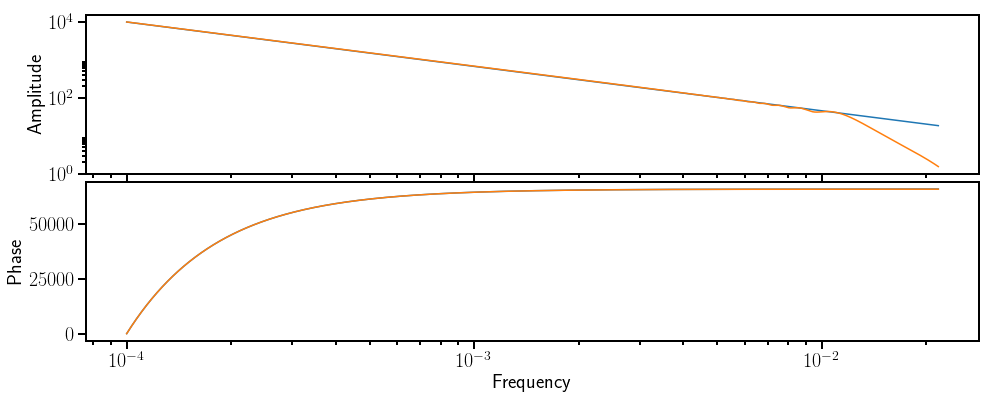

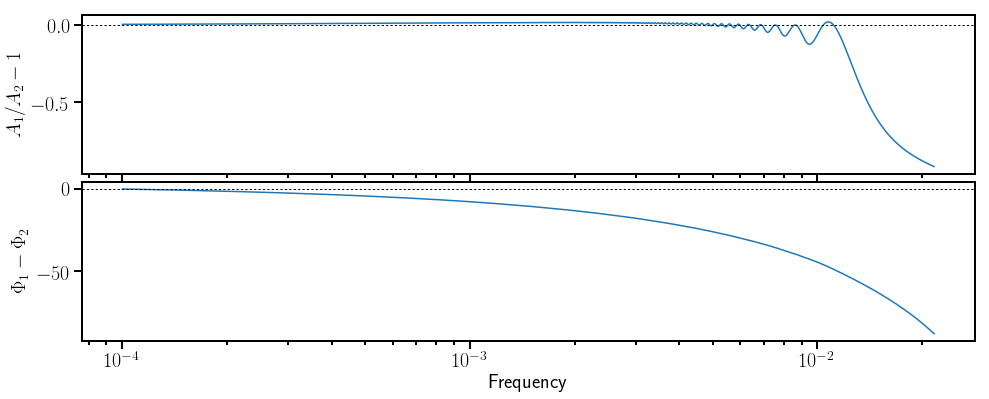

In [253]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_ref, h_cond1])
#fig, (ax1, ax2) = wave.plot_waveforms_fd([h_cond1, h_cond2, h_ref])
ax1.set_yscale('log')
#ax1.axhline(1.0, ls=':', c='k')
#ax1.set_ylim(1.0e-1, 1.5)
#ax1.set_xlim(0.003, 0.03)

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(h_cond1, h_ref, xi=None, xf=None, npoints=100000)
#ax1.set_xscale('linear')
#ax1.set_xlim(0.0, 0.001)
#ax1.set_ylim(-0.05, 0.05)
#ax2.set_ylim(-10, 10)

# Make a list of conditioned waveforms

In [305]:
def td_waveform_to_conditioned_fd_waveform(
    f_min, delta_t, 
    winon_i, winon_f, winoff_i, winoff_f, 
    n_ext,
    trunc_i, trunc_f, npoints=10000, 
    win='planck', f_coalescence=None, remove_start_phase=True, 
    approximant='SpinTaylorT4', amplitude_order=0, 
    q=1.0, 
    spin1x=0.0, spin1y=0.0, spin1z=0.0, 
    spin2x=0.0, spin2y=0.0, spin2z=0.0, 
    lambda1=0.0, lambda2=0.0):
    """Generate a time-domain waveform, then condition and Fourier transform it.
    """
    h = dimensionless_td_waveform(approximant=approximant, q=q, 
                               spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                               spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                               lambda1=lambda1, lambda2=lambda2, 
                               mf_min=f_min, delta_tbym=delta_t, amplitude_order=amplitude_order)
    
    h_cond = condition_waveform(h,
                       winon_i, winon_f, winoff_i, winoff_f, 
                       n_ext,
                       trunc_i, trunc_f, npoints=npoints, 
                       win=win, f_coalescence=f_coalescence, remove_start_phase=remove_start_phase)

    return h_cond



def td_waveform_to_conditioned_fd_waveform_difference_with_fd(
    f_min, delta_t, 
    winon_i, winon_f, winoff_i, winoff_f, 
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=10000, 
    win='planck', f_coalescence=None, remove_start_phase=True, 
    approximant='SpinTaylorT4', amplitude_order=0, 
    q=1.0, 
    spin1x=0.0, spin1y=0.0, spin1z=0.0, 
    spin2x=0.0, spin2y=0.0, spin2z=0.0, 
    lambda1=0.0, lambda2=0.0):
    """Generate a time-domain waveform, then condition and Fourier transform it.
    Then subtract a frequency-damain reference waveform.
    """
    h = dimensionless_td_waveform(approximant=approximant, q=q, 
                spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                lambda1=lambda1, lambda2=lambda2, 
                mf_min=f_min, delta_tbym=delta_t, amplitude_order=amplitude_order)
    
    h_cond = condition_waveform(h,
                winon_i, winon_f, winoff_i, winoff_f, 
                n_ext,
                trunc_i, trunc_f, npoints=npoints, 
                win=win, f_coalescence=f_coalescence, remove_start_phase=remove_start_phase)
    
    # Generate FD wavefrom between trunc_i and trunc_f with same parameters
    h_ref = dimensionless_fd_waveform(approximant='TaylorF2', 
                q=q, 
                spin1x=spin1x, spin1y=spin1y, spin1z=spin1z, 
                spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, 
                lambda1=lambda1, lambda2=lambda2,
                mf_min=trunc_i, mf_max=trunc_f, delta_mf=ref_delta_f)
    
    wave.resample_uniform(h_ref, npoints=npoints, spacing='log', order=2)
    
    h_ref.add_phase(remove_start_phase=remove_start_phase)
    
    dh = train.lnamp_phase_difference(h_cond, h_ref, npoints=npoints, spacing='log', order=2)
    return h_cond, dh


def make_training_set(
    h_filename, dh_filename, params,
    f_min, delta_t, 
    winon_i, winon_f, winoff_i, winoff_f, 
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=10000, 
    win='planck', f_coalescence=None, remove_start_phase=True, 
    approximant='SpinTaylorT4', amplitude_order=0):
    """Make a WaveformSet containing waveforms with parameters params.
    """
    h_ts = ws.HDF5WaveformSet(h_filename)
    dh_ts = ws.HDF5WaveformSet(dh_filename)
    for i in range(len(params)):
        p = params[i]
        q, spin1z, spin2z, lambda1, lambda2 = p
        print i, p
        
        h, dh = td_waveform_to_conditioned_fd_waveform_difference_with_fd(
            f_min, delta_t, 
            winon_i, winon_f, winoff_i, winoff_f, 
            n_ext,
            trunc_i, trunc_f, ref_delta_f, npoints=npoints, 
            win=win, f_coalescence=f_coalescence, remove_start_phase=remove_start_phase, 
            approximant=approximant, amplitude_order=amplitude_order, 
            q=q, 
            spin1z=spin1z, spin2z=spin2z, 
            lambda1=lambda1, lambda2=lambda2)
        
        h_ts.set_waveform(i, h, p)
        dh_ts.set_waveform(i, dh, p)

    h_ts.close()
    dh_ts.close()

# Calculate relative interpolation requirements for h and dh

In [273]:
def range_of_freq(h_list):
    """Calculate the max and min values of the amplitude and range
    as a function of frequency.
    """
    freq = h_list[0].x
    nwave = len(h_list)
    nfreq = len(freq)
    
    amps = np.array([h_list[i].amp for i in range(nwave)])
    amp_min = np.array([np.min(amps[:, j]) for j in range(nfreq)])
    amp_max = np.array([np.max(amps[:, j]) for j in range(nfreq)])
    
    phases = np.array([h_list[i].phase for i in range(nwave)])
    phase_min = np.array([np.min(phases[:, j]) for j in range(nfreq)])
    phase_max = np.array([np.max(phases[:, j]) for j in range(nfreq)])
    
    return freq, amp_min, amp_max, phase_min, phase_max

In [297]:
# Parameters for the training set
Ndata = 25
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
#limits = np.array([[0.5, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0, 5000], [0, 5000]])
params = doe.latin_hypercube(Ndata, limits)

f_min = 0.0004
delta_t = 10.0
approximant = 'SpinTaylorT4'
amp_ord = 0

min_total_time = 4.0*zero_pn_coalescence_time(f_min, 1.0)
n_ext = next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

winon_i = f_min
winon_f = 0.0005
winoff_i = 0.009
winoff_f = 0.010
trunc_i = winon_f
trunc_f = MF_ISCO
npoints = 10000
win = 'planck'
f_coalescence = winoff_f

ref_delta_f = 1.0e-8

16993795.3652 2097152


In [298]:
h_cond_list = []
dh_list = []
for i in range(len(params)):
    p = params[i]
    q, spin1z, spin2z, lambda1, lambda2 = p
    print p
    
    h, dh = td_waveform_to_conditioned_fd_waveform_difference_with_fd(
        f_min, delta_t, 
        winon_i, winon_f, winoff_i, winoff_f, 
        n_ext,
        trunc_i, trunc_f, ref_delta_f, npoints=npoints, 
        win=win, f_coalescence=f_coalescence, remove_start_phase=True, 
        approximant=approximant, 
        q=q, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2)
    
    h_cond_list.append(h)
    dh_list.append(dh)

[  4.16666667e-01  -2.91666667e-01  -5.83333333e-02   9.16666667e+03
   0.00000000e+00]
[  9.16666667e-01  -5.83333333e-01  -2.33333333e-01   8.75000000e+03
   9.16666667e+03]
[  3.33333333e-01   2.33333333e-01  -5.83333333e-01   6.66666667e+03
   7.08333333e+03]
[  9.72222222e-01  -5.25000000e-01  -1.75000000e-01   8.33333333e+02
   3.33333333e+03]
[  7.50000000e-01   5.83333333e-02   5.83333333e-01   4.16666667e+03
   1.00000000e+04]
[  5.27777778e-01  -3.50000000e-01   2.91666667e-01   5.00000000e+03
   2.50000000e+03]
[  3.88888889e-01   2.91666667e-01   7.00000000e-01   7.50000000e+03
   2.91666667e+03]
[  9.44444444e-01  -1.11022302e-16   4.66666667e-01   7.91666667e+03
   5.41666667e+03]
[  5.55555556e-01  -2.33333333e-01  -4.08333333e-01   1.66666667e+03
   5.83333333e+03]
[  3.61111111e-01   5.25000000e-01   5.83333333e-02   4.16666667e+02
   4.58333333e+03]
[  7.22222222e-01   4.66666667e-01  -2.91666667e-01   5.83333333e+03
   1.25000000e+03]
[  6.38888889e-01  -4.66666667e-

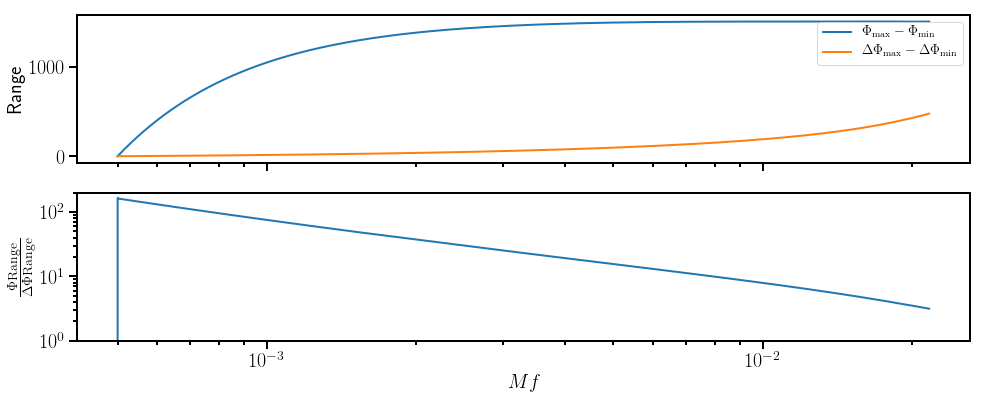

In [299]:
freq1, amp_min1, amp_max1, phase_min1, phase_max1 = range_of_freq(h_cond_list)
freq2, amp_min2, amp_max2, phase_min2, phase_max2 = range_of_freq(dh_list)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16, 6))

ax1.plot(freq1, phase_max1-phase_min1, ls='-', lw=2, label=r'$\Phi_{\rm max}-\Phi_{\rm min}$')
ax1.plot(freq2, phase_max2-phase_min2, ls='-', lw=2, label=r'$\Delta\Phi_{\rm max}-\Delta\Phi_{\rm min}$')
ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_ylim(0.1, 1.0e4)
ax1.set_ylabel('Range')
ax1.legend()

ax2.plot(freq1, (phase_max1-phase_min1)/(phase_max2-phase_min2), ls='-', lw=2)
#ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1.0, 200.)
ax2.set_xlabel('$Mf$')
ax2.set_ylabel(r'$\frac{\Phi{\rm Range}}{\Delta\Phi {\rm Range}}$')

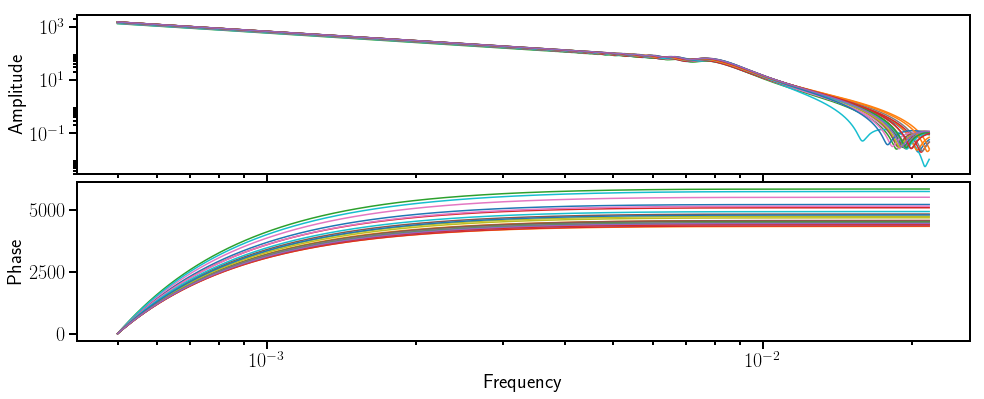

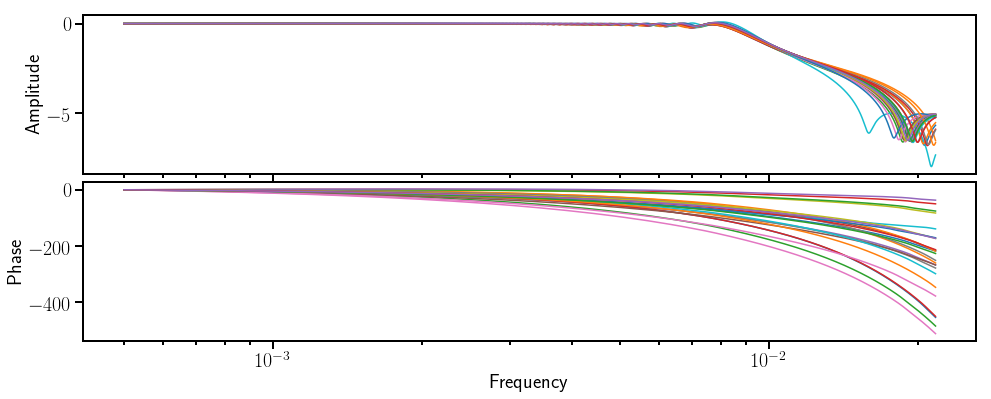

In [300]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(h_cond_list)
ax1.set_yscale('log')
#ax2.set_yscale('log')
#ax2.set_ylim(0, 10000)

fig, (ax1, ax2) = wave.plot_waveforms_fd(dh_list)
#ax2.set_yscale('log')
#ax2.set_ylim(0, 10000)

In [282]:
q = 0.6
spin1z_arr = np.linspace(-0.7, 0.7, 51)
spin2z = 0.2
lambda1 = 2000.0
lambda2 = 1000.0

h_cond_list = []
dh_list = []
for spin1z in spin1z_arr:
    print spin1z, 
    
    h, dh = td_waveform_to_conditioned_fd_waveform_difference_with_fd(
        f_min, delta_t, 
        winon_i, winon_f, winoff_i, winoff_f, 
        n_ext,
        trunc_i, trunc_f, ref_delta_f, npoints=npoints, 
        win=win, f_coalescence=f_coalescence, remove_start_phase=True, 
        approximant=approximant, 
        q=q, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2)
    
    h_cond_list.append(h)
    dh_list.append(dh)

-0.7
-0.672
-0.644
-0.616
-0.588
-0.56
-0.532
-0.504
-0.476
-0.448
-0.42
-0.392
-0.364
-0.336
-0.308
-0.28
-0.252
-0.224
-0.196
-0.168
-0.14
-0.112
-0.084
-0.056
-0.028
0.0
0.028
0.056
0.084
0.112
0.14
0.168
0.196
0.224
0.252
0.28
0.308
0.336
0.364
0.392
0.42
0.448
0.476
0.504
0.532
0.56
0.588
0.616
0.644
0.672
0.7


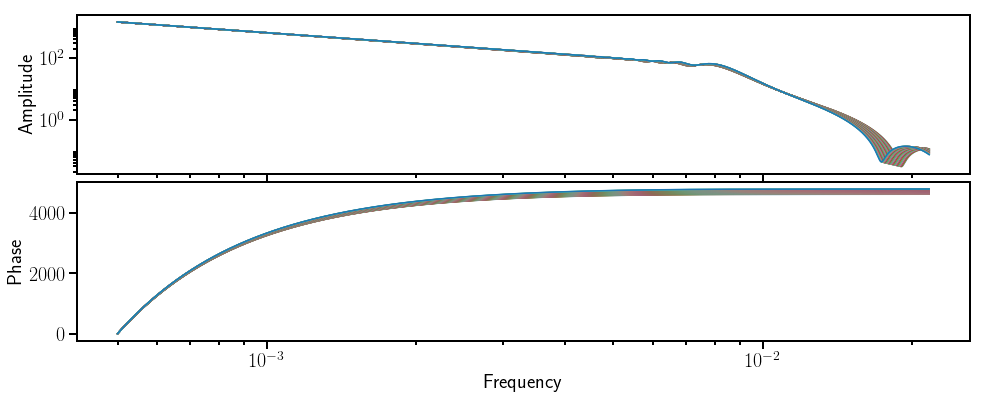

In [287]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(h_cond_list)
ax1.set_yscale('log')
#ax1.axhline(1.0, ls=':', c='k')
#ax1.set_ylim(0.5, 1.5)
#ax1.set_xlim(0.0005, 0.03)

0.01 725.090869704


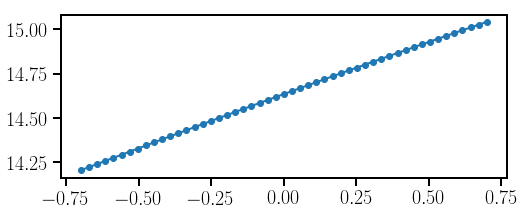

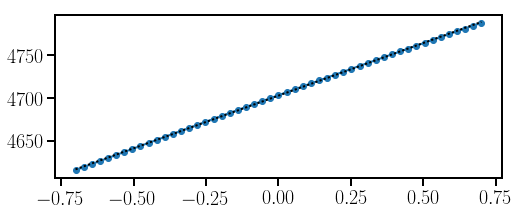

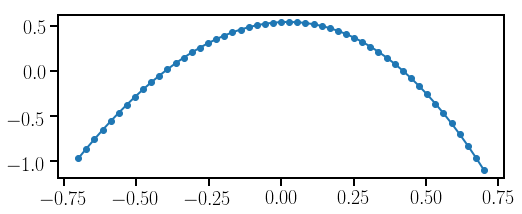

In [284]:
mf = 0.01
print mf, mf_to_f(mf, 2.8)

ps = []
amps = []
for i in range(len(h_cond_list)):
    p = spin1z_arr[i]
    h = h_cond_list[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(h_cond_list)):
    p = spin1z_arr[i]
    h = h_cond_list[i]
    phase = h.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)

0.01 725.090869704


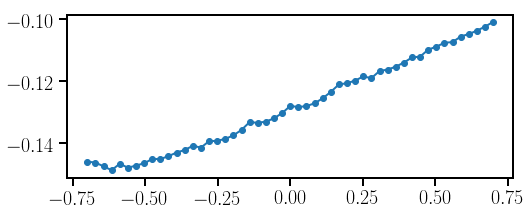

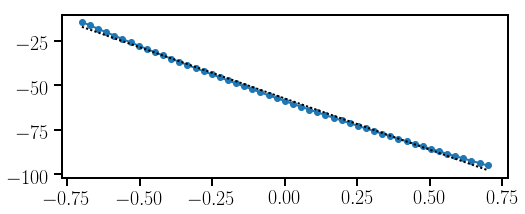

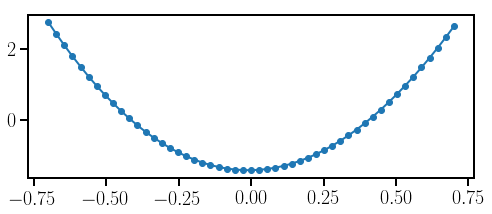

In [285]:
mf = 0.01
print mf, mf_to_f(mf, 2.8)

ps = []
amps = []
for i in range(len(h_diff_list)):
    p = spin1z_arr[i]
    h = h_diff_list[i]
    amp = h.interpolate('amp')(mf)
    ps.append(p)
    amps.append(amp)
amps = np.array(amps)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, amps, 'o', ls='-', lw=2)

ps = []
phases = []
for i in range(len(h_diff_list)):
    p = spin1z_arr[i]
    h = h_diff_list[i]
    phase = h.interpolate('phase')(mf)
    ps.append(p)
    phases.append(phase)
phases=np.array(phases)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(ps, phases)
x_fit = spin1z_arr
y_fit = intercept + slope*x_fit

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases, 'o', ls='-', lw=2)
axes.plot(x_fit, y_fit, ls=':', lw=2, c='k')

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(ps, phases-y_fit, 'o', ls='-', lw=2)

# Save training set to file

In [306]:
# Parameters for the training set
Ndata = 25
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
#limits = np.array([[0.5, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0, 5000], [0, 5000]])
params = doe.latin_hypercube(Ndata, limits)


h_filename = 'h_training_set.hdf5'
dh_filename = 'dh_training_set.hdf5'

f_min = 0.0004
delta_t = 10.0
approximant = 'SpinTaylorT4'
amp_ord = 0

min_total_time = 4.0*zero_pn_coalescence_time(f_min, 1.0)
n_ext = next_pow_2(min_total_time, delta_t)
print min_total_time, n_ext

winon_i = f_min
winon_f = 0.0005
winoff_i = 0.009
winoff_f = 0.010
trunc_i = winon_f
trunc_f = MF_ISCO
npoints = 10000
win = 'planck'
f_coalescence = winoff_f

ref_delta_f = 1.0e-8

make_training_set(
    h_filename, dh_filename, params,
    f_min, delta_t, 
    winon_i, winon_f, winoff_i, winoff_f, 
    n_ext,
    trunc_i, trunc_f, ref_delta_f, npoints=npoints, 
    win=win, f_coalescence=f_coalescence, remove_start_phase=True, 
    approximant=approximant, amplitude_order=amp_ord)

16993795.3652 2097152
0 [  9.44444444e-01   2.33333333e-01  -4.66666667e-01   0.00000000e+00
   8.75000000e+03]
1 [  8.05555556e-01  -2.33333333e-01  -2.91666667e-01   2.91666667e+03
   5.83333333e+03]
2 [  5.55555556e-01  -6.41666667e-01   1.16666667e-01   2.50000000e+03
   1.00000000e+04]
3 [  3.88888889e-01   5.83333333e-02   2.91666667e-01   6.25000000e+03
   6.25000000e+03]
4 [  4.44444444e-01   5.83333333e-01   4.08333333e-01   4.58333333e+03
   9.16666667e+03]
5 [  6.66666667e-01  -7.00000000e-01  -4.08333333e-01   4.16666667e+03
   4.16666667e+02]
6 [  3.33333333e-01  -5.83333333e-02  -6.41666667e-01   5.00000000e+03
   9.58333333e+03]
7 [  9.16666667e-01   1.75000000e-01   6.41666667e-01   4.16666667e+02
   7.50000000e+03]
8 [  5.00000000e-01   4.08333333e-01  -7.00000000e-01   7.08333333e+03
   5.00000000e+03]
9 [  8.88888889e-01  -1.75000000e-01   7.00000000e-01   5.41666667e+03
   1.25000000e+03]
10 [  7.77777778e-01  -1.16666667e-01  -5.83333333e-02   9.16666667e+03
   6.6

In [307]:
h_trainset = ws.HDF5WaveformSet(h_filename)
dh_trainset = ws.HDF5WaveformSet(dh_filename)

In [314]:
len(h_trainset), len(dh_trainset)

(25, 25)

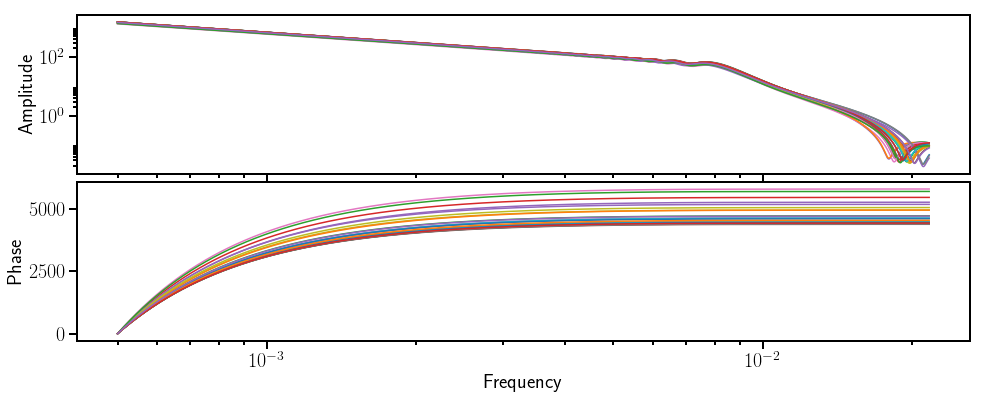

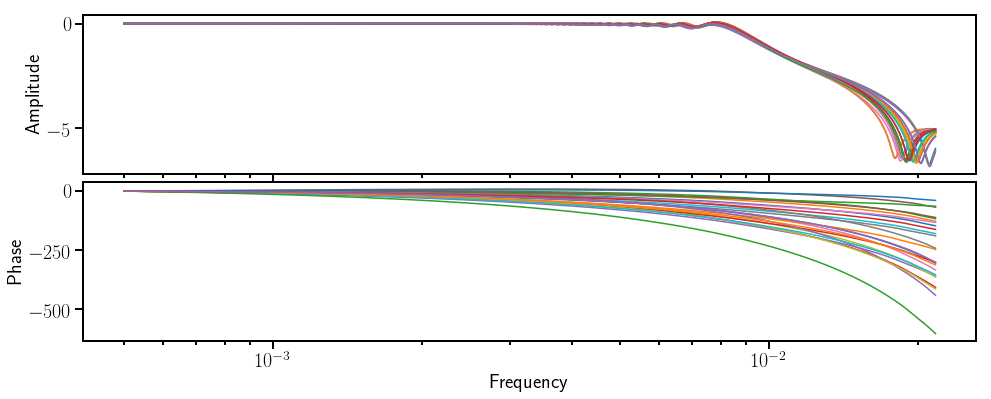

In [318]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_trainset[i] for i in range(len(h_trainset))])
ax1.set_yscale('log')
#ax2.set_yscale('log')
#ax2.set_ylim(0, 10000)

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_trainset[i] for i in range(len(dh_trainset))])
#ax2.set_yscale('log')
#ax2.set_ylim(0, 10000)